
# Predicting Basketball Player Styles Using Regular Season Data


## **Definition of the Problem**

Basketball players have different ways of playing, usually grouped into three types: offensive, defensive, and balanced. Offensive players focus on scoring points and helping their team on offense. Defensive players work on stopping the other team from scoring and disrupting their plays. Balanced players do a mix of both, helping with scoring and defense.

As a basketball fan and researcher, I’m interested in how we can use performance stats from regular-season games to figure out a player’s style of play. This project aims to make it easier to classify players into these three groups based on their stats. The results can help coaches make better decisions and improve team strategies.

## **Data Acquisition**

The datasets used for this project include the following:

1. **Regular Season Box Scores (2010–2024):** This dataset contains detailed player statistics for regular season games and was sourced from a GitHub repository. The repository appears to have collected the data through web scraping and is updated twice a year to ensure its accuracy and relevance. A standout feature of this dataset is its completeness—it includes data for all players, whether they played in a particular game or not, and covers every regular season game from 2010 to 2024. This level of detail ensures comprehensive analysis of player performance.

2. **Basketball Players' Styles:** This dataset provides labels that categorize players' playing styles (offensive, defensive, or balanced). These labels were manually gathered through online research, where each player’s style was looked up and categorized based on publicly available information.

Together, these datasets offer a robust foundation for analyzing and classifying basketball players' playing styles using both quantitative game performance data and qualitative style categorization.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


### Code to Load the Data:


In [2]:
# File paths for the datasets
file_paths = [
    "data/regular_season_box_scores_2010_2024_part_1.csv",
    "data/regular_season_box_scores_2010_2024_part_2.csv",
    "data/regular_season_box_scores_2010_2024_part_3.csv",
]
styles_path = "data/basketball_players_styles.csv"

# Load regular season data
regular_season_data = pd.concat([pd.read_csv(file) for file in file_paths], ignore_index=True)

# Load player styles data
styles_data = pd.read_csv(styles_path)

# Merge datasets on player names
regular_season_data = pd.merge(
    regular_season_data,
    styles_data[['Player', 'Style']],
    left_on='personName',
    right_on='Player',
    how='left'
)

## **Exploration and Analysis of Data**

### Understanding the Dataset:
- **Regular Season Data** contains performance metrics like points, assists, rebounds, and shooting percentages.
- **Styles Data** maps players to playing styles: Offensive, Defensive, and Balanced.

### Descriptive Statistics:

In [3]:
# General info and statistics
print(regular_season_data.info())
print(regular_season_data.describe())

# Check missing values
missing_values = regular_season_data.isnull().sum()
print(f"Missing values:\n{missing_values}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424478 entries, 0 to 424477
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   season_year              424478 non-null  object 
 1   game_date                424478 non-null  object 
 2   gameId                   424478 non-null  int64  
 3   matchup                  424478 non-null  object 
 4   teamId                   424478 non-null  int64  
 5   teamCity                 424478 non-null  object 
 6   teamName                 424478 non-null  object 
 7   teamTricode              424478 non-null  object 
 8   teamSlug                 424478 non-null  object 
 9   personId                 424478 non-null  int64  
 10  personName               424478 non-null  object 
 11  position                 166580 non-null  object 
 12  comment                  73005 non-null   object 
 13  jerseyNum                0 non-null       float64
 14  minu

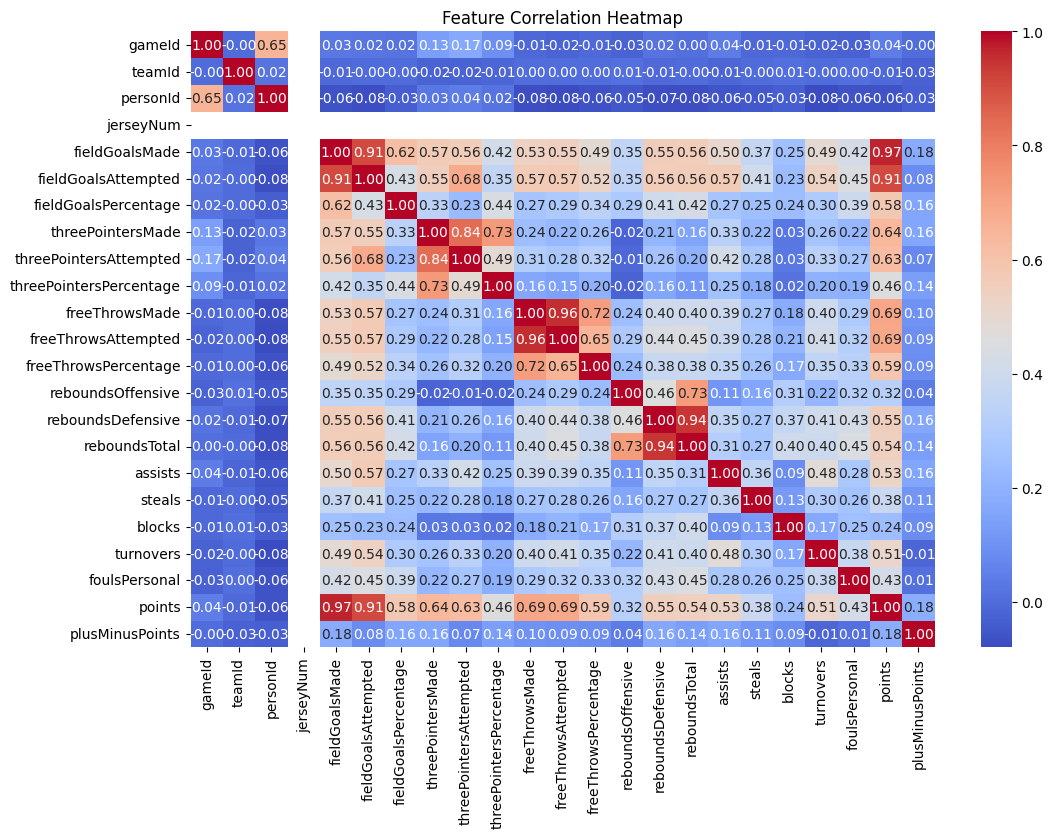

In [4]:
# Correlation heatmap for numerical features
numerical_data = regular_season_data.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

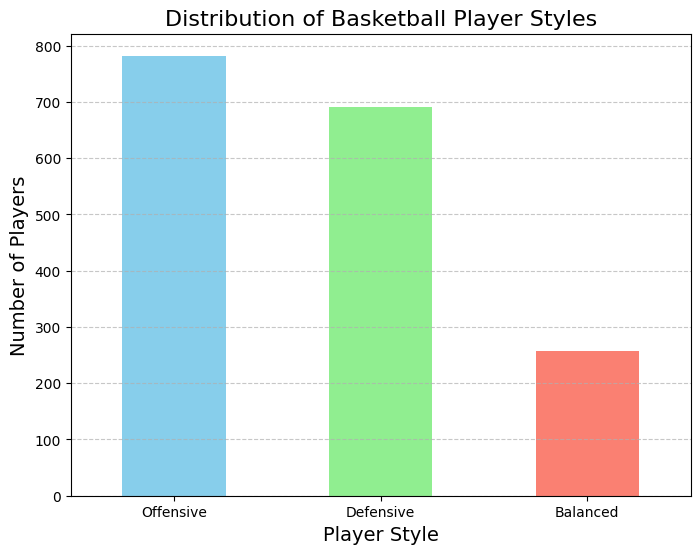

In [5]:
# Count the number of players in each style category
style_counts = styles_data['Style'].value_counts()

# Plot the distribution of player styles
plt.figure(figsize=(8, 6))
style_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Distribution of Basketball Player Styles', fontsize=16)
plt.xlabel('Player Style', fontsize=14)
plt.ylabel('Number of Players', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## **Data Preparation**

### Cleaning the Data:
- **Handle Missing Values:** Drop rows with missing `Style` labels and fill other NaNs with 0 or 'Unknown.'
- **Remove Did Not Play:** Drop rows where there is a comment indicating the player did not play (e.g., coach's decision, injury, sick).
- **Transform Time:** Convert time strings (e.g., '5:30 minutes' to 5.5) to numeric values.
- **Map Styles to Labels:** Map 'Offensive', 'Defensive', and 'Balanced' to 0, 1, and 2, respectively.

In [6]:
# Remove rows where there is a comment, as it indicates the player did not play
regular_season_data = regular_season_data[regular_season_data['comment'].isna()]

# Map 'Style' to numerical labels
style_mapping = {'Offensive': 0, 'Defensive': 1, 'Balanced': 2}
regular_season_data['style_label'] = regular_season_data['Style'].map(style_mapping)

# Drop rows with missing labels
regular_season_data = regular_season_data.dropna(subset=['style_label'])

# Convert time strings to float
def time_to_float(time_str):
    try:
        minutes, seconds = map(int, time_str.split(':'))
        return minutes + seconds / 60
    except (ValueError, AttributeError):
        return 0.0

regular_season_data['minutes'] = regular_season_data['minutes'].apply(time_to_float)

# Fill other missing values
regular_season_data.fillna(0, inplace=True)

/var/folders/1q/rjywqsc52dx1v_bb1s6w9wxh0000gn/T/ipykernel_96458/2218948060.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  regular_season_data.fillna(0, inplace=True)


### Feature Selection and Standardization:
- **Selected Features:** Points, rebounds, assists, steals, etc.
- **One-Hot Encoding:** Encode player positions (F, G, C, Unknown).
- **Z-Score Normalization:** Standardize numerical features.

In [7]:
# Select features
features = [
    'minutes', 'fieldGoalsMade', 'fieldGoalsAttempted', 'fieldGoalsPercentage', 
    'threePointersMade', 'threePointersAttempted', 'threePointersPercentage', 
    'freeThrowsMade', 'freeThrowsAttempted', 'freeThrowsPercentage', 
    'reboundsOffensive', 'reboundsDefensive', 'reboundsTotal', 'assists', 
    'steals', 'blocks', 'turnovers', 'foulsPersonal', 'points', 'plusMinusPoints'
]

# Fill missing values in position with 'Unknown'
regular_season_data['position'] = regular_season_data['position'].fillna('Unknown')
# One-hot encode position
position_encoded = pd.get_dummies(regular_season_data['position'], prefix='pos')
regular_season_data = pd.concat([regular_season_data, position_encoded], axis=1)

features.extend(position_encoded.columns.tolist())

# Standardize features
scaler = StandardScaler()
regular_season_data[features] = scaler.fit_transform(regular_season_data[features])


## **Determination of Training, Validation, and Testing Datasets**


### Group-Based Split:
Ensure no overlap of players across datasets by splitting on `personName`.


In [8]:
# Get a list of unique player names from the dataset
players = regular_season_data['personName'].unique()

# Split the players into training and temporary sets
# 70% of the players will be in the training set, and 30% will be in the temporary set
train_players, temp_players = train_test_split(players, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets
# Each will contain 15% of the total players (half of the temporary set)
val_players, test_players = train_test_split(temp_players, test_size=0.5, random_state=42)

# Create the training dataset by selecting rows where the player is in the training set
train_data = regular_season_data[regular_season_data['personName'].isin(train_players)]

# Create the validation dataset by selecting rows where the player is in the validation set
val_data = regular_season_data[regular_season_data['personName'].isin(val_players)]

# Create the test dataset by selecting rows where the player is in the test set
test_data = regular_season_data[regular_season_data['personName'].isin(test_players)]